In [20]:
# Requirements: pip install yfinance pandas_datareader statsmodels numpy pandas
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Linear regression analysis between silver futures and silver-gold ratios
---

In [15]:
# Silver daily (COMEX front-month via yfinance ticker 'SI=F') and SLV
start = '1900-01-01'

silver = yf.download('SI=F', start=start)['Close'].squeeze().rename('silver')
slv = yf.download('SLV', start=start)['Close'].squeeze().rename('slv')
gold = yf.download('GC=F', start=start)['Close'].squeeze().rename('gold')
gld = yf.download('GLD', start=start)['Close'].squeeze().rename('gld')

df = pd.concat([silver,slv,gold,gld], axis=1).dropna()

df.head()

/var/folders/cx/gx6njnbj39qgss912bmvd5d40000gn/T/ipykernel_7349/2634980941.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver = yf.download('SI=F', start=start)['Close'].squeeze().rename('silver')
[*********************100%***********************]  1 of 1 completed
/var/folders/cx/gx6njnbj39qgss912bmvd5d40000gn/T/ipykernel_7349/2634980941.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  slv = yf.download('SLV', start=start)['Close'].squeeze().rename('slv')
[*********************100%***********************]  1 of 1 completed
/var/folders/cx/gx6njnbj39qgss912bmvd5d40000gn/T/ipykernel_7349/2634980941.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download('GC=F', start=start)['Close'].squeeze().rename('gold')
[*********************100%***********************]  1 of 1 completed
/var/folders/cx/gx6njnbj39qgss912bmvd5d40000gn/T/ipykernel_7349/2634980941.py:7: Future

,silver,slv,gold,gld
Date,,,,
2006-04-28,13.510,13.812,651.799988,65.089996
2006-05-01,13.852,13.870,657.500000,65.160004
2006-05-02,14.110,14.365,664.700012,66.550003
2006-05-03,13.704,13.925,665.900024,66.459999
2006-05-04,13.735,14.000,674.200012,67.480003


In [16]:
df['sgr'] = df["slv"] / df['gld']
print(f'corr of slv and sgr: {df['silver'].corr(df['sgr'])}')

corr of slv and sgr: 0.1931664750262396


A weak positive correlation between the two

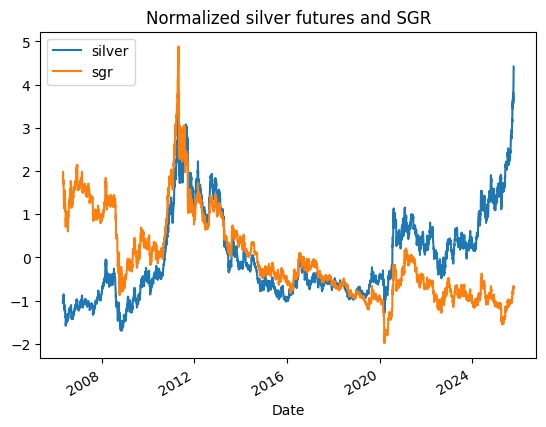

In [17]:
df_norm = (df - df.mean()) / df.std()
df_norm[['silver', 'sgr']].plot(title='Normalized silver futures and SGR')
plt.show()

Let's run the model

In [18]:
Y = df['silver']
X = sm.add_constant(df['sgr'])

mdl = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print(mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                 silver   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     15.89
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           6.80e-05
Time:                        21:10:12   Log-Likelihood:                -16532.
No. Observations:                4893   AIC:                         3.307e+04
Df Residuals:                    4891   BIC:                         3.308e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0377      1.473     10.209      0.0


# Outtakes
---
Only about 3.7% of daily variation of future prices is linearly explained by SGR. Serial correlation implies your errors aren’t independent, so predictive confidence is overstated. So, statistically, the model describes a weak association, not a reliable forecast. Let's run a t-test for emphasis.

---


In [21]:
x = df['sgr']
y = df['silver']
r, _ = stats.pearsonr(x, y)
n = len(df)

# t statistic
t = r * np.sqrt((n - 2) / (1 - r**2))
p = 1 - stats.t.cdf(t, df=n-2)  # one-sided test for r > 0
print(f"r={r:.3f}, t={t:.3f}, p={p:.3f}")


r=0.193, t=13.769, p=0.000


# Clearly reject null
## What about spot prices?
---

In [13]:
Y = df['slv']

mdl = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print(mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                    slv   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     31.96
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           1.66e-08
Time:                        21:03:36   Log-Likelihood:                -16082.
No. Observations:                4893   AIC:                         3.217e+04
Df Residuals:                    4891   BIC:                         3.218e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1439      1.347      9.014      0.0

---
Only slightly better

In [22]:
y = df['slv']
r, _ = stats.pearsonr(x, y)
n = len(df)

# t statistic
t = r * np.sqrt((n - 2) / (1 - r**2))
p = 1 - stats.t.cdf(t, df=n-2)  # one-sided test for r > 0
print(f"r={r:.3f}, t={t:.3f}, p={p:.3f}")


r=0.271, t=19.727, p=0.000


# Still reject null